# Project 4.1: Seasonality

# Import Modules

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.spatial
import recurrence as rc
import RQA
import recurrence_quantification as rec

# Import data

In [2]:
# Load the grayscale dataset

data_dir = 'data/'

df_grayscale = pd.read_csv(data_dir + 'grayscale.txt', sep = '\t',header=0)

# Define necessary functions which are not included in the modules

1. Function to assign wet or dry season to an age

In [3]:
# wet season is expected to be from Oct - May and dry season from May until Oct

#start of october (Time is given in BP, so year starts in December, then follows November etc.)

decimal_oct = 3/12

# start of may

decimal_may = 8/12

def wet_or_dry(decimal_year):
    
    year = int(decimal_year)
    rem = decimal_year - year
    
    #dry season
    
    if decimal_oct < rem  < decimal_may:
        
        return 0
    
    #wet season
    
    else:
        
        return 1

2. Assign months to an age

In [4]:
# Convert the decimal places to actual months

def assign_months(value):
    
    yr = int(value)
    
    x = value - yr
    
    if x > 11/12:
        
        return 1
    
    if 11/12 > x > 10/12:
        
        return 2
    
    if 10/12 > x > 9/12:
        
        return 3
    
    if 9/12 > x > 8/12:
        
        return 4
    
    if 8/12 > x > 7/12:
        
        return 5
    
    if 7/12 > x > 6/12:
        
        return 6
    
    if 6/12 > x > 5/12:
        
        return 7
    
    if 5/12 > x > 4/12:
        
        return 8
    
    if 4/12 > x > 3/12:
        
        return 9
    
    if 3/12 > x > 2/12:
        
        return 10
    
    if 2/12 > x > 1/12:
        
        return 11
    
    if 1/12 > x > 0/12:
        
        return 12

3. Extract the year of an age

In [5]:
def extract_year_from_decimal_year(year):
    
    res = int(year)
    
    return res

4. A function to make recurrence plots

In [6]:
def recurrence_matrix(array, emb = False, delay = None, dim = None, perc_th = None):
    
    '''Returns a recurrence matrix of an array.
    If emb = True, an embedding is performed with given delay and dimension.
    Perc_th defines percentile of the distances which should be used in the
    recurrence plot.'''
    
    if emb == False:
        
        a_rm = np.zeros((array.shape[0], 2))
        a_rm[:,0] = array
        a_rm[:,1] = array
        a_rm_dis = scipy.spatial.distance.pdist(a_rm)
        a_rm_sq = scipy.spatial.distance.squareform(a_rm_dis)
        th = np.percentile(a_rm_sq, perc_th)
        a_rec = np.where(a_rm_sq < th, 1, 0)
        
        return a_rec
    
    else:
        
        a_emb = rc.embed(array, dim, delay)
        a_emb_dis = scipy.spatial.distance.pdist(a_emb)
        a_data_emb_dis_sq = scipy.spatial.distance.squareform(a_emb_dis)
        th = np.percentile(a_data_emb_dis_sq, perc_th)
        a_rec = np.where(a_data_emb_dis_sq < th, 1, 0)
        
        return a_rec

5. Recurrence Rate

In [7]:
def recurrence_rate(rp):
    
    return rp.sum()/(rp.shape[0]*rp.shape[0])

6. Function to split recurrence plot along the line of identity in sliding windows

In [8]:
def split_recurrence_plot_sliding(rp, window_size, step_size):
    
    start_ind = 0
    
    l_result = []
    
    for i in range(rp[0:-window_size:step_size].shape[0]):
        
        res = rp[start_ind:start_ind+window_size, start_ind:start_ind+window_size]
        
        l_result.append(res)
        
        start_ind+=step_size
    
    return l_result

7. Function to count the number of empty vertical lines

In [9]:
def number_of_white_vertical_lines(rp):
    
    a_sum = (np.sum(rp, axis = 0)-1)

    return sum(a_sum == 0)

# Prepare different data frames for each data analysis

**Make a seasonal difference data frame**

In [11]:
# Index all values as either dry or wet season

df_grayscale['Season'] = df_grayscale['Age '].apply(wet_or_dry)

# make a new data frame that consists of a sequence of dry and wet seasons

df_seasonal = df_grayscale.groupby([(df_grayscale.Season != df_grayscale.Season.shift()).cumsum()], as_index=False).mean()

# since time is given in BP, the time series should start at 6214

df_seasonal = df_seasonal.sort_values(by=['Age '], ascending = False)

# add the year to make it more clear when the season started

df_seasonal['Year'] = df_seasonal['Age '].apply(extract_year_from_decimal_year)

df_seasonal.head(10)

,Age,GS,Season,Year
1606,6214.327062,161.051688,0,6214
1605,6213.967626,186.981173,1,6213
1604,6213.490600,160.448828,0,6213
1603,6212.961829,176.601294,1,6212
1602,6212.456955,165.685182,0,6212
1601,6211.970443,173.938357,1,6211
1600,6211.482975,160.259750,0,6211
1599,6210.978056,162.417333,1,6210
1598,6210.394525,156.143650,0,6210
1597,6209.911282,183.487177,1,6209


**Calculate the running difference between each succeeding season "Seasonal Contrast"**

As seasonality can be understood as the contrast in the grayscale values of dry and wet seasons, the difference from each season to the next is calculated.

In [12]:
df_seasonal['Seasonal GS Difference'] = df_seasonal[' GS'].diff()

df_seasonal.head(10)

,Age,GS,Season,Year,Seasonal GS Difference
1606,6214.327062,161.051688,0,6214,NaN
1605,6213.967626,186.981173,1,6213,25.929485
1604,6213.490600,160.448828,0,6213,-26.532345
1603,6212.961829,176.601294,1,6212,16.152467
1602,6212.456955,165.685182,0,6212,-10.916112
1601,6211.970443,173.938357,1,6211,8.253175
1600,6211.482975,160.259750,0,6211,-13.678607
1599,6210.978056,162.417333,1,6210,2.157583
1598,6210.394525,156.143650,0,6210,-6.273683
1597,6209.911282,183.487177,1,6209,27.343527


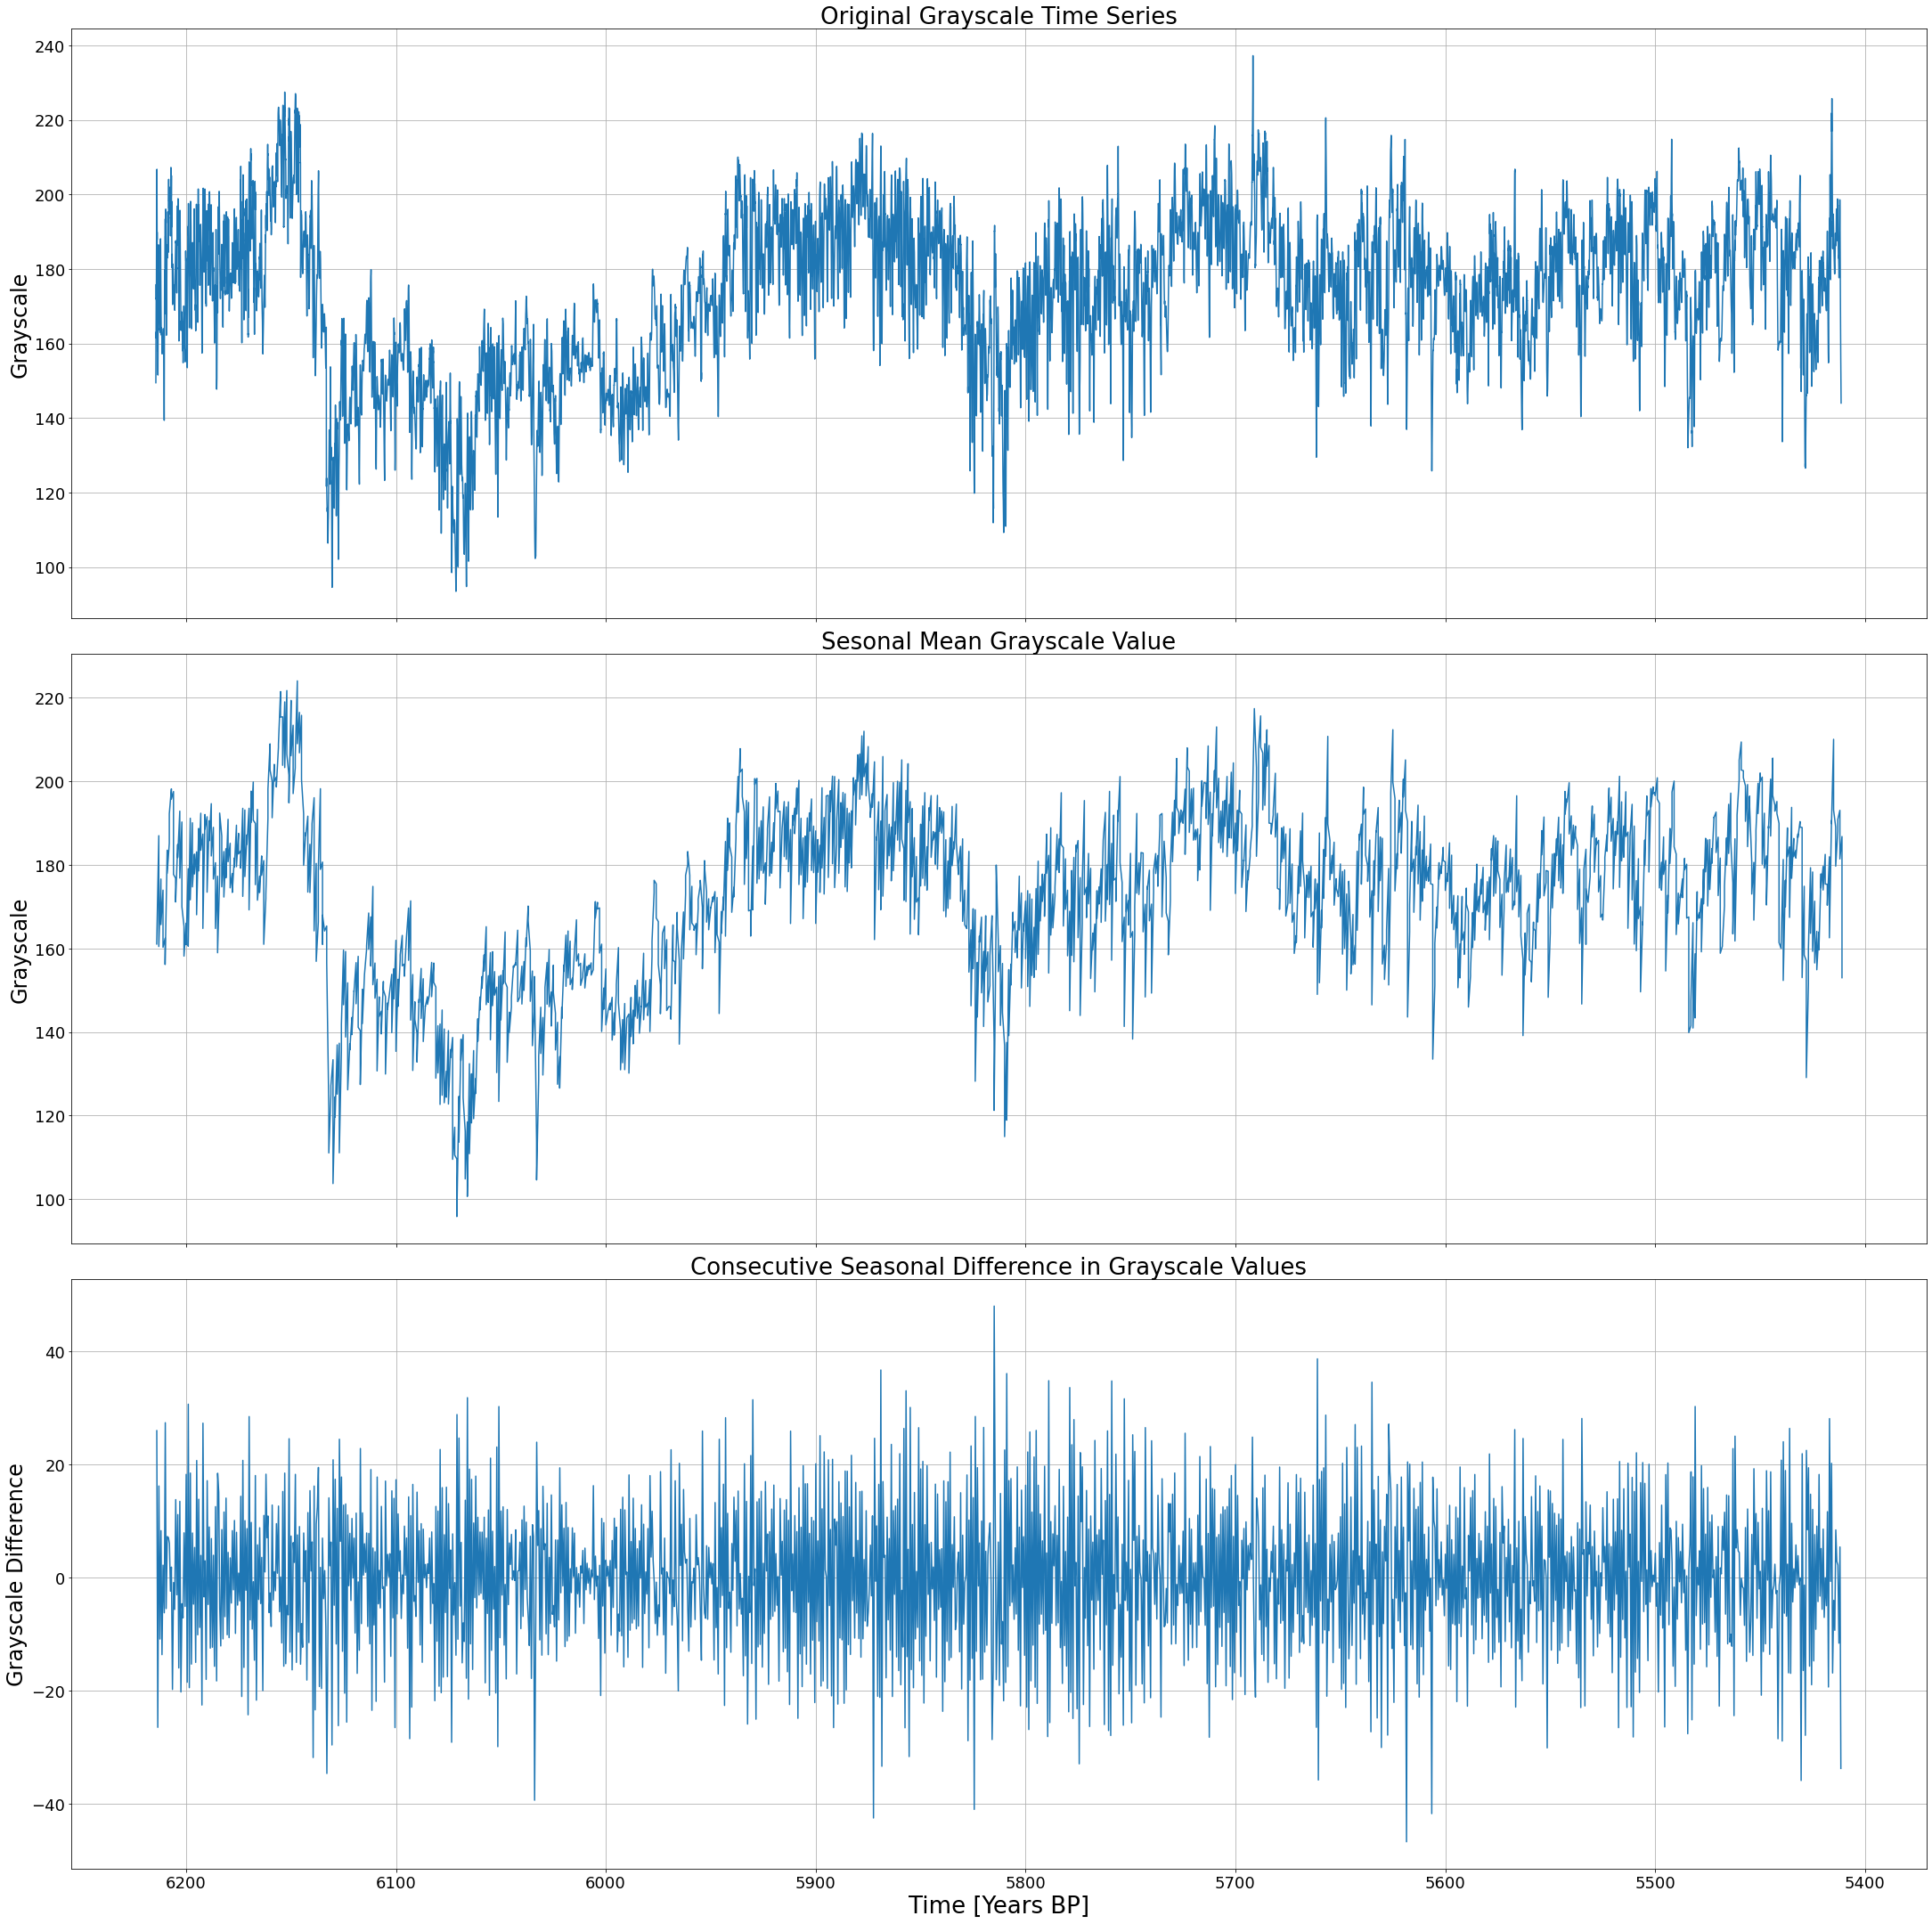

In [297]:
fig, axs = plt.subplots(3,1, figsize = (30,30), sharex=True)

axs[0].plot(df_grayscale['Age '], df_grayscale[' GS'])
axs[0].invert_xaxis()
axs[0].set_ylabel('Grayscale', fontsize = 24)
axs[0].grid()
axs[0].set_title('Original Grayscale Time Series', fontsize = 26);

axs[1].plot(df_seasonal['Year'], df_seasonal[' GS'])
axs[1].set_ylabel('Grayscale', fontsize = 24)
axs[1].grid()
axs[1].set_title('Sesonal Mean Grayscale Value', fontsize = 26);

axs[2].plot(df_seasonal['Age '], df_seasonal['Seasonal GS Difference'])
axs[2].set_ylabel('Grayscale Difference', fontsize = 24)
axs[2].set_xlabel('Time [Years BP]', fontsize = 26)
axs[2].grid()
axs[2].set_title('Consecutive Seasonal Difference in Grayscale Values', fontsize = 26);

plt.tight_layout()

plt.setp(axs[2].get_xticklabels(), fontsize=18)

for i in range(3):
    
    plt.setp(axs[i].get_yticklabels(), fontsize=18)

plt.savefig('Time_Series.png', format = 'png', dpi = 300)

# Analysis

There seem to be periods where the contrast between dry and wet seasons are stronger pronounced and periods where it is lower. To see if there are any regularities a recurrence plot is done.

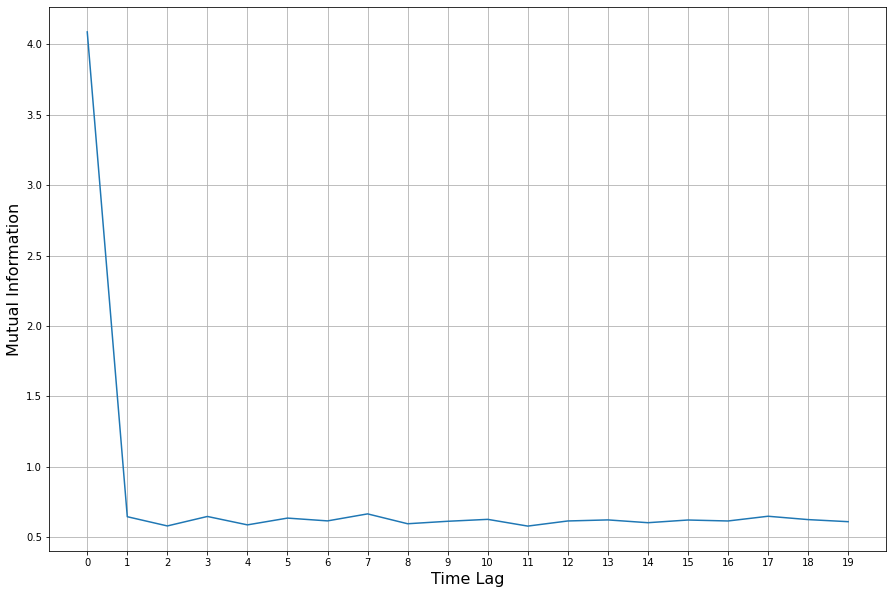

In [17]:
# Calculate the mutual information up to 20 to find the optimal lag for this time series

# first value in the time series is NaN, so it has to start from the second

a_diff_mi = rc.mi(df_seasonal['Seasonal GS Difference'][1:], 20)

plt.figure(figsize=(15,10))
plt.plot(a_diff_mi[1], a_diff_mi[0])
plt.grid()
plt.xticks(a_diff_mi[1]);
plt.ylabel('Mutual Information', fontsize = 16)
plt.xlabel('Time Lag', fontsize = 16);

The optimal lag is where the mutual information changes from exponential to linear decline. This is the case at a lag of 2. Next step is to find the optimal embedding dimension based on that lag.

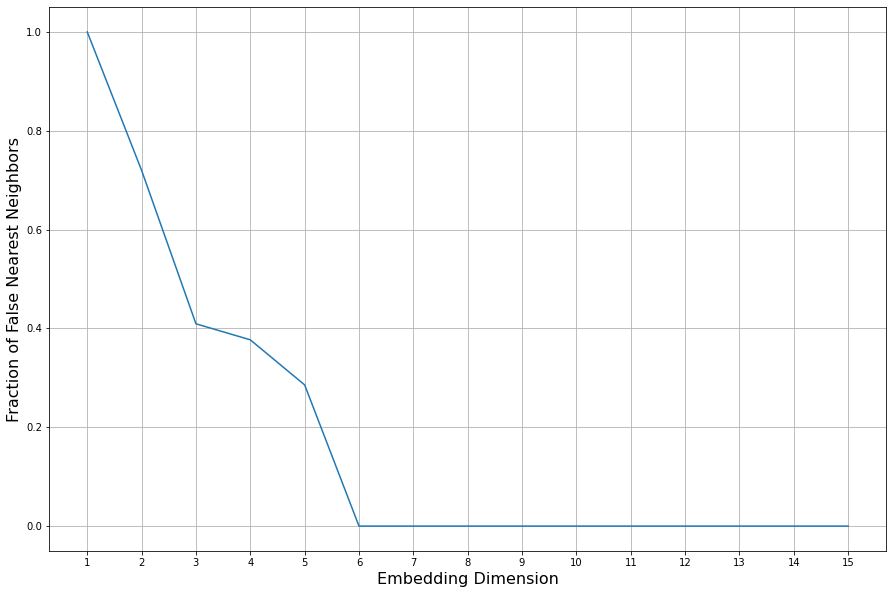

In [18]:
# calculate the false-nearest-neighbours up to 15 dimensions

seasonal_diff_fnn = rc.fnn(np.asarray(df_seasonal['Seasonal GS Difference'][1:]), tau = 1, maxdim=15)

plt.figure(figsize=(15,10))
plt.plot(seasonal_diff_fnn[1], seasonal_diff_fnn[0])
plt.grid();
plt.xticks(seasonal_diff_fnn[1]);
plt.ylabel('Fraction of False Nearest Neighbors', fontsize = 16)
plt.xlabel('Embedding Dimension', fontsize = 16);

At an embedding dimension of 6 the fraction of false nearest neighbours is 0 and is therefore the optimal option.

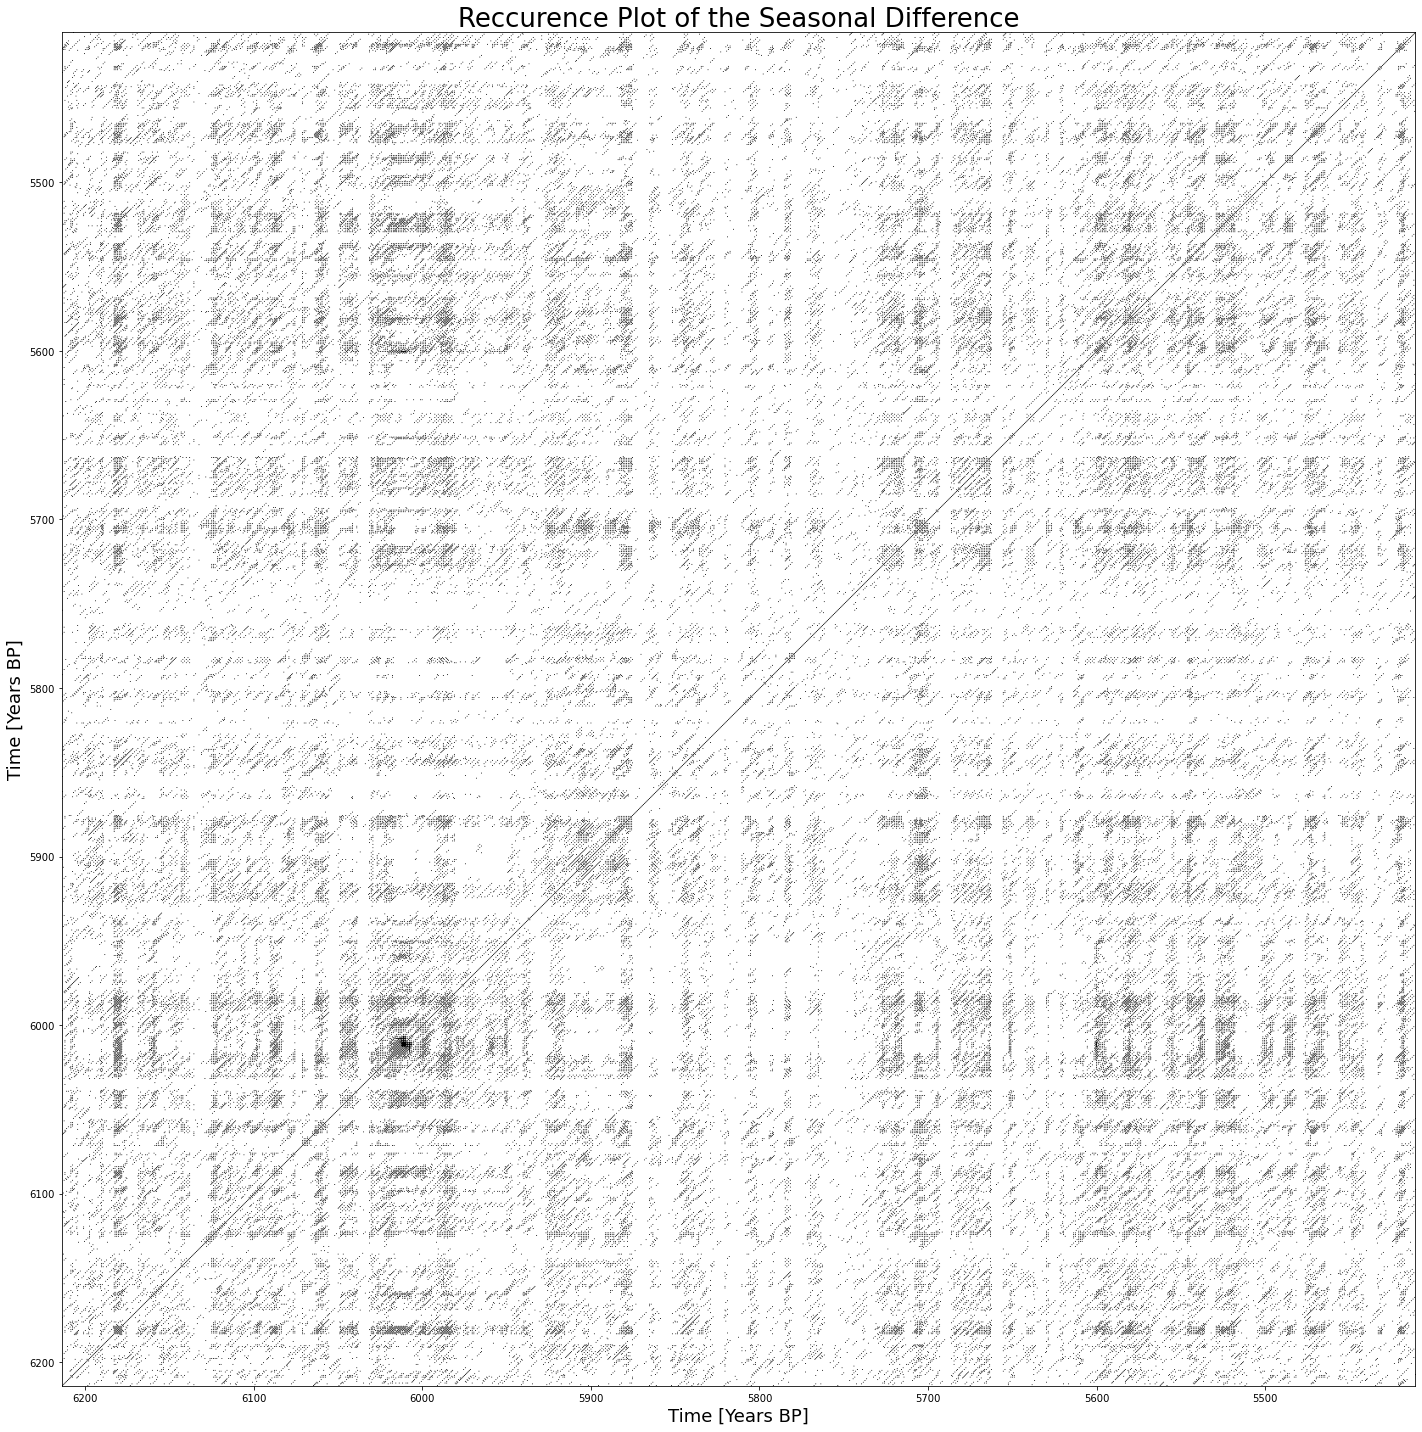

In [16]:
rp = recurrence_matrix(np.asarray(df_seasonal['Seasonal GS Difference'][1:]), emb = True, delay = 2, dim = 6, perc_th=5)

plt.figure(figsize=(20, 20))
plt.imshow(rp, cmap = 'binary', origin = 'lower', extent=[6214, 5411, 6214, 5411]);
plt.title('Reccurence Plot of the Seasonal Difference', fontsize = 26)
plt.ylabel('Time [Years BP]', fontsize = 18)
plt.xlabel('Time [Years BP]', fontsize = 18);
plt.tight_layout()
plt.savefig('Seasonal_difference_RP.png', format = 'png', dpi = 300)

In [19]:
from itertools import chain

def diagonal_lines_hist(R, verb=True):
    """returns the histogram P(l) of diagonal lines of length l."""
    if verb:
        print("diagonal lines histogram...")
    line_lengths = []
    for i in range(1, len(R)):
        d = np.diag(R, k=i)
        ll = _count_num_lines(d)
        line_lengths.append(ll)
    line_lengths = np.array(list(chain.from_iterable(line_lengths)))
    bins = np.arange(0.5, line_lengths.max() + 0.1, 1.)
    num_lines, _ = np.histogram(line_lengths, bins=bins)
    return num_lines, bins, line_lengths


def _count_num_lines(arr):
    """returns a list of line lengths contained in given array."""
    line_lens = []
    counting = False
    l = 0
    for i in range(len(arr)):
        if counting:
            if arr[i] == 0:
                l += 1
                line_lens.append(l)
                l = 0
                counting = False
            elif arr[i] == 1:
                l += 1
                if i == len(arr) - 1:
                    l += 1
                    line_lens.append(l)
        elif not counting:
            if arr[i] == 1:
                counting = True
    return line_lens



def entr(R, lmin=None, hist=None, verb=True):
    """returns ENTROPY for given recurrence matrix R."""
    if not lmin:
        lmin = int(0.1 * len(R))
    if not hist:
        if verb: print("estimating line length histogram...")
        nlines, bins, ll = diagonal_lines_hist(R, verb=verb)
    else:
        nlines, bins, ll = hist[0], hist[1], hist[2]
    if verb: print("estimating ENTR...")
    pl = nlines.astype('float') / float(len(ll))
    l = (0.5 * (bins[:-1] + bins[1:])).astype('int')
    idx1 = l >= lmin
    pl = pl[idx1]
    idx = pl > 0.
    ENTR = (-pl[idx] * np.log(pl[idx])).sum()
    return ENTR

In [21]:
rp_rr = recurrence_rate(rp2)
rp_det = RQA.det(rp2)
rp_max_dia = RQA.diagonal_lines_hist(rp2)[2].max()
rp_avg_line = RQA.diagonal_lines_hist(rp2)[2].mean()
rp_entr = entr(rp2, lmin=2, verb = False)
rp_white_lines = number_of_white_vertical_lines(rp2)

print(rp_rr, rp_det, rp_max_dia, rp_avg_line, rp_entr, rp_white_lines)

0.04999968593162103 0.0 23 1.2061655923879682 0.3121806876257439 37


**Split the seasonal difference time series into smaller subwindows with window size 100 and stepsize of 10**

In [17]:
l_split_rp = split_recurrence_plot_sliding(rp, 100, 10)

In [21]:
# Calculate the recurrence rate for each window

l_rr = [recurrence_rate(slpit_rp) for slpit_rp in l_split_rp]

# Determinism

l_det = [RQA.det(slpit_rp) for slpit_rp in l_split_rp]

# longest diagonal line length

l_long_diag_line = [RQA.diagonal_lines_hist(slpit_rp)[2].max() for slpit_rp in l_split_rp]

# average diagonal line length

l_avg_diag_line = [RQA.diagonal_lines_hist(slpit_rp)[2].mean() for slpit_rp in l_split_rp]

# Entropy of diagonal lines with minimum line length of 2

l_entropy = [rec.entr(slpit_rp, lmin = 2, verb= False) for slpit_rp in l_split_rp]

# white lines 

l_white_lines = [number_of_white_vertical_lines(split_rp) for split_rp in l_split_rp]

/home/stefan/Schreibtisch/Nonlinear/Final Project/RQA.py:86: RuntimeWarning: invalid value encountered in double_scalars
  DET = num.sum() / den.sum()


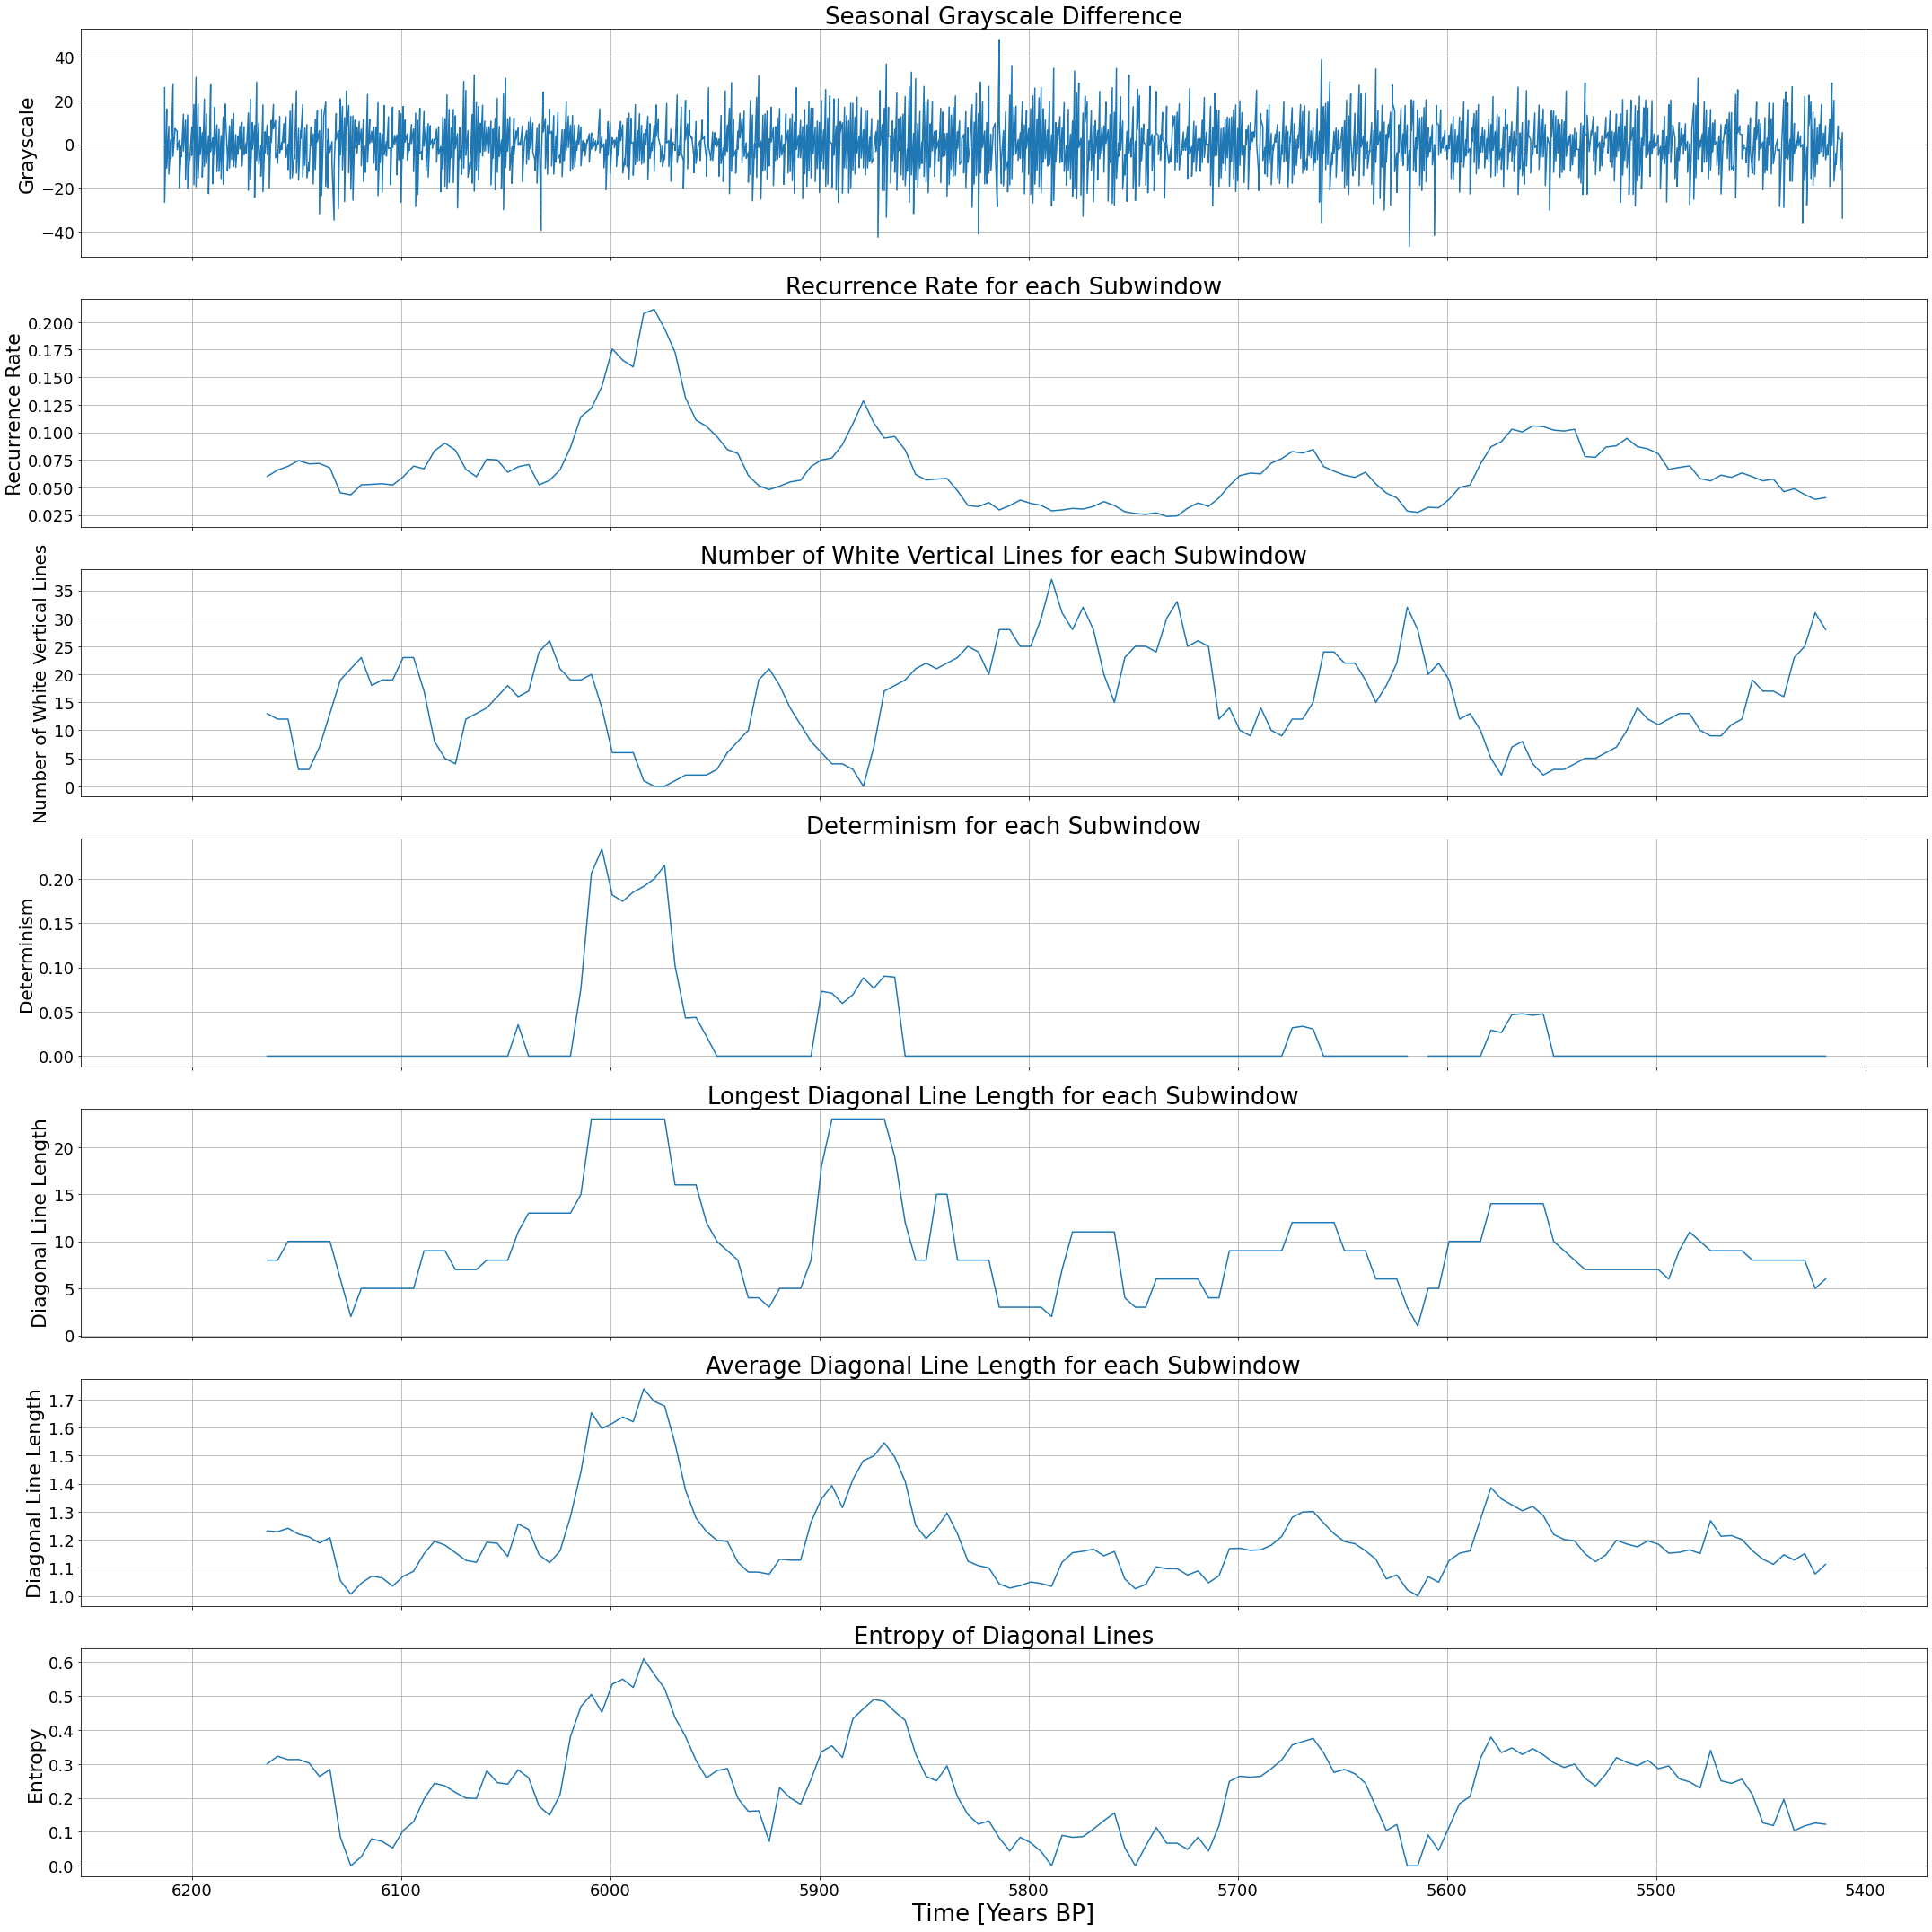

In [22]:
fig, axs = plt.subplots(7,1, figsize = (30,30), sharex=True)

axs[0].plot(df_seasonal['Year'], df_seasonal['Seasonal GS Difference'])
axs[0].set_ylabel('Grayscale', fontsize = 22)
axs[0].grid()
axs[0].invert_xaxis()
axs[0].set_title('Seasonal Grayscale Difference', fontsize = 26);

axs[1].plot(df_seasonal['Year'][100::10][:-1], l_rr)
axs[1].set_ylabel('Recurrence Rate', fontsize = 22)
axs[1].grid()
axs[1].set_title('Recurrence Rate for each Subwindow', fontsize = 26);

axs[2].plot(df_seasonal['Year'][100::10][:-1], l_white_lines)
axs[2].set_ylabel('Number of White Vertical Lines', fontsize = 20)
axs[2].grid()
axs[2].set_title('Number of White Vertical Lines for each Subwindow', fontsize = 26);

axs[3].plot(df_seasonal['Year'][100:-1:10][:-1], l_det)
axs[3].set_ylabel('Determinism', fontsize = 20)
axs[3].grid()
axs[3].set_title('Determinism for each Subwindow', fontsize = 26);

axs[4].plot(df_seasonal['Year'][100:-1:10][:-1], l_long_diag_line)
axs[4].set_ylabel('Diagonal Line Length', fontsize = 22)
axs[4].grid()
axs[4].set_title('Longest Diagonal Line Length for each Subwindow', fontsize = 26);

axs[5].plot(df_seasonal['Year'][100:-1:10][:-1], l_avg_diag_line)
axs[5].set_ylabel('Diagonal Line Length', fontsize = 22)
axs[5].grid()
axs[5].set_title('Average Diagonal Line Length for each Subwindow', fontsize = 26);

axs[6].plot(df_seasonal['Year'][100:-1:10][:-1], l_entropy)
axs[6].set_ylabel('Entropy', fontsize = 22)
axs[6].grid()
axs[6].set_title('Entropy of Diagonal Lines', fontsize = 26)
axs[6].set_xlabel('Time [Years BP]', fontsize = 26)


plt.setp(axs[6].get_xticklabels(), fontsize=18)

for i in range(7):
    
    plt.setp(axs[i].get_yticklabels(), fontsize=18)
    
plt.tight_layout()

#plt.savefig('RQA.png', format = 'png', dpi = 300)